In my case: I needed downgrade to pandas =0.23.4: for that I have **separate environment**

Link: https://stackoverflow.com/questions/55656401/pymatch-giving-error-when-fitting-unable-to-coerce-to-series-length-must-be-1

https://proglib.io/p/analysis-hacks

In [307]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.neighbors import BallTree,NearestNeighbors

from sklearn.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings

dataset type setting

In [308]:
path_to_loan_data = "datasets/loan.csv"
path_to_catholic_vs_math_data = "datasets/catholic_school_vs_math.csv"

In [309]:
path = path_to_catholic_vs_math_data

other

In [310]:
if (path == path_to_catholic_vs_math_data):
    k = 4

In [311]:
sumulations_n = 500
rr = 1

In [312]:
data_tmp = pd.read_csv(path)
data_tmp.head()

,childid,catholic,race,race_white,race_black,race_hispanic,race_asian,p5numpla,p5hmage,p5hdage,...,w3daded_hsb,w3momed_hsb,w3momscr,w3dadscr,w3inccat,w3income,w3povrty,p5fstamp,c5r2mtsc,c5r2mtsc_std
0,0001002C,0,"WHITE, NON-HISPANIC",1,0,0,0,1.000,47.000,45.000,...,0.000,0.000,53.500,77.500,"$50,001 TO $75,000","62,500.500",0.000,0.000,60.043,0.982
1,0001004C,0,"WHITE, NON-HISPANIC",1,0,0,0,1.000,41.000,48.000,...,0.000,0.000,34.950,53.500,"$40,001 TO $50,000","45,000.500",0.000,0.000,56.280,0.594
2,0001005C,0,"WHITE, NON-HISPANIC",1,0,0,0,nan,nan,nan,...,nan,nan,nan,nan,NaN,nan,nan,nan,53.791,0.338
3,0001010C,0,"WHITE, NON-HISPANIC",1,0,0,0,1.000,43.000,55.000,...,0.000,0.000,63.430,53.500,"$50,001 TO $75,000","62,500.500",0.000,0.000,55.272,0.491
4,0001011C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.000,38.000,39.000,...,0.000,0.000,53.500,53.500,"$75,001 TO $100,000","87,500.500",0.000,0.000,64.604,1.451


In [313]:
data_tmp.shape

(11078, 22)

In [314]:
data_tmp.columns

Index(['childid', 'catholic', 'race', 'race_white', 'race_black',
       'race_hispanic', 'race_asian', 'p5numpla', 'p5hmage', 'p5hdage',
       'w3daded', 'w3momed', 'w3daded_hsb', 'w3momed_hsb', 'w3momscr',
       'w3dadscr', 'w3inccat', 'w3income', 'w3povrty', 'p5fstamp', 'c5r2mtsc',
       'c5r2mtsc_std'],
      dtype='object')

In [315]:
data_tmp.loc[data_tmp.index==0].to_csv("temp.csv")

### raw dataset readings

In [316]:
if (path == path_to_catholic_vs_math_data):
    data = pd.read_csv(path, usecols = ['race_white'
                                        , 'p5hmage'
                                        , 'w3income'
                                        , 'p5numpla'
                                        , 'w3momed_hsb'
                                        ,'catholic'
                                        , 'c5r2mtsc'
                                        ,'childid' #it is an id --ruined all
                                       ])
    data.dropna(inplace = True)
    ##data['index_initial_p'] = list(range(0, data.shape[0])) --ruined all
    data['p5numpla'] = pd.to_numeric(data['p5numpla'], downcast = 'integer')
    #data is separable for 'p5numpla'
    data = data.loc[data.p5numpla<4]
    
    data['w3momed_hsb'] = pd.to_numeric(data['w3momed_hsb'], downcast = 'integer')
   
    data['p5numpla'] =data['p5numpla'].astype('category')
    data['w3momed_hsb'] =data['w3momed_hsb'].astype('category')
    data['race_white'] =data['race_white'].astype('category')
    
    data['w3income'] = data['w3income']/1000.0
    
    trt_column = 'catholic'
    
    trgt_column_raw = 'c5r2mtsc'
    trgt_column = 'c5r2mtsc_sd'
    
    scaler = StandardScaler()
    scaler.fit(np.array(data[trgt_column_raw]).reshape(-1, 1))
    data[trgt_column] = scaler.transform(np.array(data[trgt_column_raw]).reshape(-1, 1))

     
    numerical_features_list = ['w3income', 'p5hmage']
    binary_features_list = ['race_white','w3momed_hsb']
    categorical_feature_list = ['p5numpla']
    
if (path == path_to_loan_data):
    data = pd.read_csv(path)

In [317]:
print(data.shape)
data.head()

(9246, 9)


,childid,catholic,race_white,p5numpla,p5hmage,w3momed_hsb,w3income,c5r2mtsc,c5r2mtsc_sd
0,0001002C,0,1,1,47.000,0,62.501,60.043,0.927
1,0001004C,0,1,1,41.000,0,45.001,56.280,0.538
3,0001010C,0,1,1,43.000,0,62.501,55.272,0.433
4,0001011C,1,1,1,38.000,0,87.501,64.604,1.399
5,0001012C,0,1,1,47.000,0,150.000,75.721,2.549


In [318]:
pd.options.display.float_format = "{:,.3f}".format
dscr = data[['catholic','race_white','p5numpla','p5hmage','w3momed_hsb','w3income','c5r2mtsc']].describe(include='all')
dscr = dscr.loc[dscr.index.isin(['unique','mean','std'])]
dscr

,catholic,race_white,p5numpla,p5hmage,w3momed_hsb,w3income,c5r2mtsc
unique,nan,2.000,3.000,nan,2.000,nan,nan
mean,0.146,nan,nan,37.865,nan,59.481,51.085
std,0.353,nan,nan,6.414,nan,45.396,9.666


#### Scaling and encoding

In [319]:
scaler = StandardScaler()
s=pd.DataFrame(scaler.fit_transform(data[numerical_features_list])
               ,columns = numerical_features_list
              ,index = data.index)

ohe = OneHotEncoder(sparse = False)
clm = []

for c in categorical_feature_list:
    clm =  clm + list(map(lambda x: c + '_' + str(x), set(data[c].tolist())))
    
o = pd.DataFrame(ohe.fit(data[categorical_feature_list]).transform(data[categorical_feature_list])
                 , columns = clm
                 ,index = data.index)

data_scaled=pd.concat([data[[trt_column, trgt_column_raw, trgt_column, 'childid']+binary_features_list]
                       ,s
                       ,o]
                      ,axis = 1
                      )
for c in clm:
    data_scaled[c] =data_scaled[c].astype('category')

print(data_scaled.shape)
data_scaled.head()

(9246, 11)


,catholic,c5r2mtsc,c5r2mtsc_sd,childid,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3
0,0,60.043,0.927,0001002C,1,0,0.067,1.424,1.000,0.000,0.000
1,0,56.280,0.538,0001004C,1,0,-0.319,0.489,1.000,0.000,0.000
3,0,55.272,0.433,0001010C,1,0,0.067,0.801,1.000,0.000,0.000
4,1,64.604,1.399,0001011C,1,0,0.617,0.021,1.000,0.000,0.000
5,0,75.721,2.549,0001012C,1,0,1.994,1.424,1.000,0.000,0.000


In [320]:
binary_features_list_extended = binary_features_list + clm

In [321]:
data.columns

Index(['childid', 'catholic', 'race_white', 'p5numpla', 'p5hmage',
       'w3momed_hsb', 'w3income', 'c5r2mtsc', 'c5r2mtsc_sd'],
      dtype='object')

In [322]:
if (path == path_to_loan_data):
    test = data[data.loan_status == "Default"]
    control = data[data.loan_status == "Fully Paid"]
    test['loan_status'] = 1
    control['loan_status'] = 0
    
    response_psm = "loan_status"
    exclude_list=[]

In [323]:
if (path == path_to_catholic_vs_math_data): 
    test = data_scaled[data.catholic == 1]
    control = data_scaled[data.catholic == 0]

    response_psm = trt_column
    exclude_list=[trgt_column_raw, trgt_column, 'childid'] + list(map(lambda x: 'p5numpla_'+str(x), range(4,6)))

In [324]:
test.head()

,catholic,c5r2mtsc,c5r2mtsc_sd,childid,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3
4,1,64.604,1.399,0001011C,1,0,0.617,0.021,1.000,0.000,0.000
39,1,52.035,0.098,0007002C,1,0,0.067,0.177,0.000,1.000,0.000
40,1,64.935,1.433,0007004C,1,0,1.994,0.489,0.000,1.000,0.000
41,1,45.630,-0.564,0007006C,1,0,0.617,-0.447,1.000,0.000,0.000
42,1,48.521,-0.265,0007008C,1,0,1.994,0.489,1.000,0.000,0.000


In [325]:
data_scaled.to_csv('temp.csv')

### Profiling

In [326]:
import pandas_profiling

In [327]:
data.head()

,childid,catholic,race_white,p5numpla,p5hmage,w3momed_hsb,w3income,c5r2mtsc,c5r2mtsc_sd
0,0001002C,0,1,1,47.000,0,62.501,60.043,0.927
1,0001004C,0,1,1,41.000,0,45.001,56.280,0.538
3,0001010C,0,1,1,43.000,0,62.501,55.272,0.433
4,0001011C,1,1,1,38.000,0,87.501,64.604,1.399
5,0001012C,0,1,1,47.000,0,150.000,75.721,2.549


In [328]:
#profile = pandas_profiling.ProfileReport(data[['catholic','race_white','p5numpla','p5hmage','w3momed_hsb','w3income','c5r2mtsc']])
#profile.to_file(outputfile="Catholic data profiling.html")

In [329]:
#d = control[['catholic','race_white','p5numpla','p5hmage','w3momed_hsb','w3income','c5r2mtsc']].describe(include="all")
#d.loc[d.index.isin(['unique','top','freq','mean','std'])]
#d

In [330]:
#d = test[['catholic','race_white','p5numpla','p5hmage','w3momed_hsb','w3income','c5r2mtsc']].describe(include="all")
#d.loc[d.index.isin(['unique','top','freq','mean','std'])]#

In [331]:
#d = data[['catholic','race_white','p5numpla','p5hmage','w3momed_hsb','w3income','c5r2mtsc']].describe(include="all")
#d.loc[d.index.isin(['unique','top','freq','mean','std'])]

### Matching

In [332]:
m = Matcher(test, control, yvar=response_psm, exclude=exclude_list)

Formula:
catholic ~ race_white+w3momed_hsb+w3income+p5hmage+p5numpla_1+p5numpla_2+p5numpla_3
n majority: 7894
n minority: 1352


In [333]:
# for reproducibility
np.random.seed(20200429)

m.fit_scores(balance=True, nmodels=6)

Fitting Models on Balanced Samples: 6\6
Average Accuracy: 65.32%


In [334]:
m.predict_scores()

In [335]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


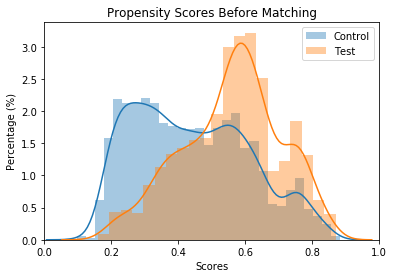

In [336]:
m.plot_scores()

In [337]:
m.data.shape

(9246, 12)

In [338]:
m.data.head()

,catholic,c5r2mtsc,c5r2mtsc_sd,childid,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3,scores
0,1,64.604,1.399,0001011C,1,0,0.617,0.021,1.000,0.000,0.000,0.622
1,1,52.035,0.098,0007002C,1,0,0.067,0.177,0.000,1.000,0.000,0.570
2,1,64.935,1.433,0007004C,1,0,1.994,0.489,0.000,1.000,0.000,0.752
3,1,45.630,-0.564,0007006C,1,0,0.617,-0.447,1.000,0.000,0.000,0.599
4,1,48.521,-0.265,0007008C,1,0,1.994,0.489,1.000,0.000,0.000,0.758


In [339]:
print("Recommended caliper:")
clpr = m.data.scores.std()/4.0
clpr

Recommended caliper:


0.04348800788901934

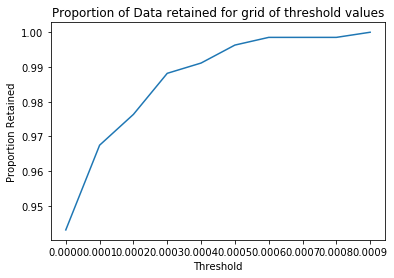

In [340]:
m.tune_threshold(method='random')

In [341]:
trs = clpr/10.0
print(trs)
trs=0.00025

0.004348800788901934


In [342]:
#trs=0.00025
m.match(method="random"
        , nmatches=1
        , threshold=trs)
#prin(m.prop_retained())#0.985
#m.assign_weight_vector()

In [343]:
m.prop_retained()

0.9829881656804734

In [344]:
m.record_frequency()

,freq,n_records
0,1,2313
1,2,140
2,3,16
3,4,3
4,5,1


In [345]:
m.assign_weight_vector()

In [346]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,catholic,c5r2mtsc,c5r2mtsc_sd,childid,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3,scores,match_id
0,0,1.000,1,64.604,1.399,0001011C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
2140,5838,1.000,0,65.870,1.530,0808017C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
1,1,1.000,1,52.035,0.098,0007002C,1,0,0.067,0.177,0.000,1.000,0.000,0.570,1
1628,2981,1.000,0,55.201,0.426,0317011C,1,0,0.067,0.177,0.000,1.000,0.000,0.570,1
2,2,1.000,1,64.935,1.433,0007004C,1,0,1.994,0.489,0.000,1.000,0.000,0.752,2
1631,2986,1.000,0,53.931,0.295,0317020C,1,0,1.994,0.333,1.000,0.000,0.000,0.752,2


In [347]:
m.matched_data.shape

(2658, 15)

### Matching Quality Review: Before and After

#### Statistics

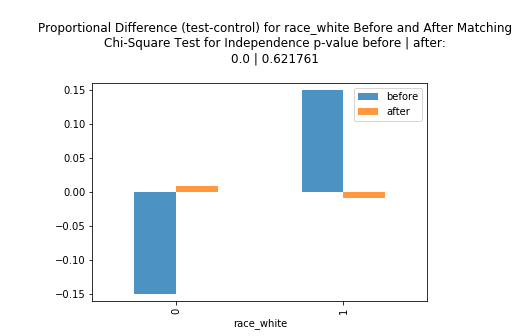

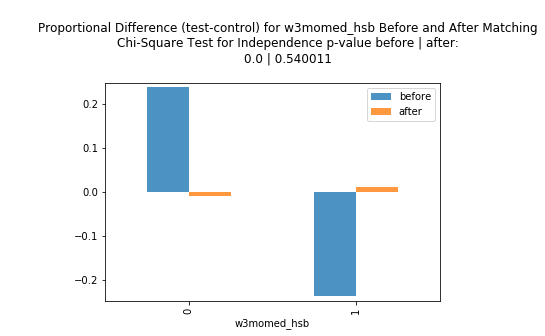

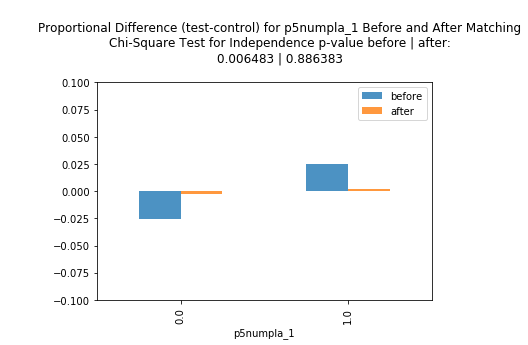

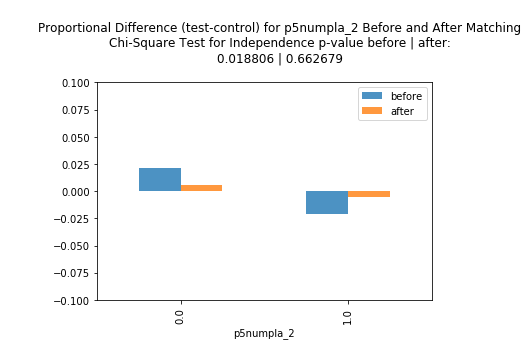

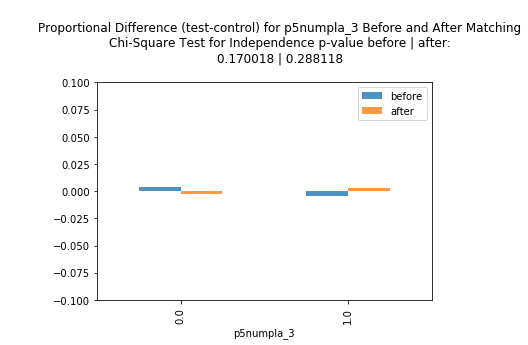

In [348]:
categorical_results = m.compare_categorical(return_table=True)

In [349]:
categorical_results

,var,before,after
0,race_white,0.000,0.622
1,w3momed_hsb,0.000,0.540
2,p5numpla_1,0.006,0.886
3,p5numpla_2,0.019,0.663
4,p5numpla_3,0.170,0.288


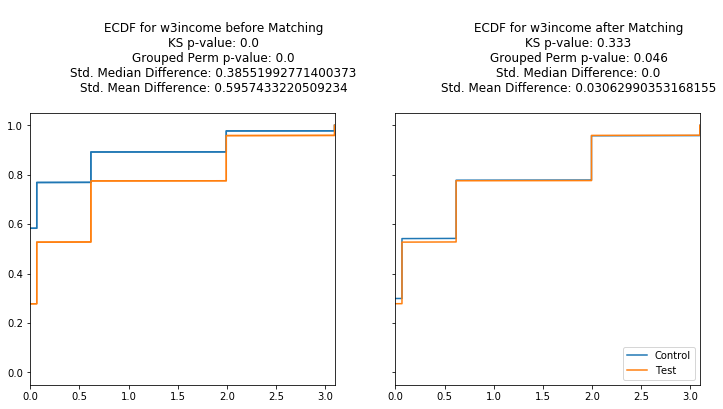

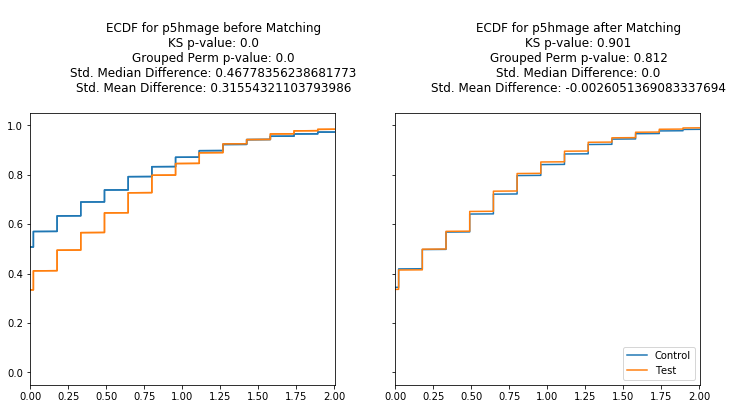

In [350]:
cc = m.compare_continuous(return_table=True)

In [351]:
descr = pd.DataFrame()
descr['value'] = ['w3income','p5hmage']

descr = pd.concat([descr
                 ,cc[['ks_before', 'ks_after', 'std_mean_diff_before', 'std_mean_diff_after']]]
                 ,axis = 1)
descr

,value,ks_before,ks_after,std_mean_diff_before,std_mean_diff_after
0,w3income,0.000,0.333,0.596,0.031
1,p5hmage,0.000,0.901,0.316,-0.003


from pymatch.Matcher import Matcher
m = Matcher(test
            , control
            , yvar=response_psm
            , exclude=exclude_list)
m.fit_scores(balance=True, nmodels=6)
m.predict_scores()
m.plot_scores()

m.tune_threshold(method='random')
m.match(method="min", nmatches=1, threshold=0.00025)
m.assign_weight_vector()
m.matched_data.sort_values("match_id").head(6)

#### Cohens

In [352]:
from numpy import var
from math import sqrt
from numpy import mean

#https://machinelearningmastery.com/effect-size-measures-in-python/
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [353]:
def cohens_h( prop_1, prop_2):

    #x1 = 2.0* np.arcsin(np.sqrt(abs(prop_1)))
    #x2 = 2.0* np.arcsin(np.sqrt(abs(prop_2)))
    #h = abs(x1-x2)
    h = abs(prop_1-prop_2)/np.sqrt((prop_1*(1-prop_1)+prop_2*(1-prop_2))*0.5)
    return(h)

In [354]:
def matching_analysis(m,numerical_features_list, binary_features_list_extended):
    d_initial=[]
    for c in numerical_features_list:
        d_current = cohend(d1=m.data.loc[m.data[trt_column]==1][c].tolist()
                       , d2=m.data.loc[m.data[trt_column]==0][c].tolist())
        d_initial.append(d_current)
    print("cohens d before")  
    print(d_initial)
    
    d_matched=[]
    for c in numerical_features_list:
        d_current = cohend(d1=m.matched_data.loc[m.data[trt_column]==1][c].tolist()
                       , d2=m.matched_data.loc[m.data[trt_column]==0][c].tolist())
        d_matched.append(d_current)

    print("cohens d after")    
    print(d_matched)
    
    h_initial=[]
    for c in binary_features_list_extended :
        prop_test = (m.data.loc[(m.data[trt_column]==1) & (m.data[c]==1)].shape[0]*1.0)/(m.data.shape[0])
        prop_control = (m.data.loc[(m.data[trt_column]==0) & (m.data[c]==1)].shape[0]*1.0)/(m.data.shape[0])
        h_initial.append(cohens_h( prop_1=prop_test, prop_2=prop_control))
    print("cohens h before") 
    print(h_initial)
    
    h_matched=[]
    for c in binary_features_list_extended :
        prop_test = (m.matched_data.loc[(m.matched_data[trt_column]==1) & (m.matched_data[c]==1)].shape[0]*1.0)/(m.matched_data.shape[0])
        prop_control = (m.matched_data.loc[(m.matched_data[trt_column]==0) & (m.matched_data[c]==1)].shape[0]*1.0)/(m.matched_data.shape[0])
        h_matched.append(cohens_h( prop_1=prop_test, prop_2=prop_control))
    print("cohens h after") 
    print(h_matched)
    
    mathing_cohens=pd.DataFrame({"features": numerical_features_list+binary_features_list_extended
                            ,'before': d_initial + h_initial
                            , 'after': d_matched + h_matched
                            })
    return(mathing_cohens)

In [355]:
matching_analysis(m,numerical_features_list, binary_features_list_extended)

cohens d before
[0.6093310140823313, 0.31748850033605486]
cohens d after
[0.016722550781192703, -0.012188612730089043]
cohens h before
[0.9527005379402826, 0.9817899554717329, 1.6156036598214258, 0.3532625672538508, 0.10989507507767726]
cohens h after
[0.00932323540728909, 0.016972153356240798, 0.0022646208465550966, 0.013677550286298246, 0.038829461770602064]


,features,before,after
0,w3income,0.609,0.017
1,p5hmage,0.317,-0.012
2,race_white,0.953,0.009
3,w3momed_hsb,0.982,0.017
4,p5numpla_1,1.616,0.002
5,p5numpla_2,0.353,0.014
6,p5numpla_3,0.110,0.039


In [356]:
m.data.to_csv("temp.csv")

### Analysis of Target Varaiable

#### For 1:1 Matching

In [357]:
from scipy.stats import ttest_ind, describe, linregress

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib as s


In [359]:
def sample_analysis(dt
                    , trt_column
                    , trgt_column
                   
                    , one_parameter_str
                    , many_parameter_str):
    cat0 = dt[dt[trt_column]==0]
    cat1 = dt[dt[trt_column]==1]
    
    descr0 = list(describe(cat0[trgt_column])[:4])
    descr1 = list(describe(cat1[trgt_column])[:4])                                                                                                                                                                                                                                                                                                                                                                                                                                 
    descr0[1]=(round(descr0[1][0],3),round(descr0[1][1],3))
    descr1[1]=(round(descr1[1][0],3),round(descr1[1][1],3))
    
    pd.options.display.float_format = "{:,.3f}".format

    print("------------------")
    print("t-test")
    print("\n  Description "+ trt_column + " = 0")
    print(pd.DataFrame({  'metric':['nobs', 'minmax', 'mean', 'variance']#, 'skewness','kurtosis']
                ,'value':descr0}))
    print("------------------")
    print("\n  Description "+ trt_column + " = 1")
    print(pd.DataFrame({  'metric':['nobs', 'minmax', 'mean', 'variance']#, 'skewness','kurtosis']
                ,'value':descr1}))
    print("------------------")
    print("\nt.test data")
    print(ttest_ind(cat0[trgt_column], cat0 [trgt_column]))
    
    results = smf.ols(one_parameter_str, dt).fit()
    print("\n------------------")
    print("OLS for TRT parameter")
    print("------------------")
    print(results.summary())
    
    results = smf.ols(many_parameter_str, dt).fit()
    print("\n------------------")
    print("OLS for ALL parameters")
    print("------------------")
    print(results.summary())
    

##### __BEFORE MATCHING__

In [360]:
sample_analysis(dt=data_scaled
                ,trt_column=trt_column
                ,trgt_column=trgt_column
                ,one_parameter_str='c5r2mtsc_sd ~ catholic'
                ,many_parameter_str='c5r2mtsc_sd ~ catholic + race_white + p5hmage + w3momed_hsb + w3income  + p5numpla_2 + p5numpla_3'
               )

------------------
t-test

  Description catholic = 0
     metric            value
0      nobs             7894
1    minmax  (-3.638, 3.391)
2      mean           -0.026
3  variance            1.037
------------------

  Description catholic = 1
     metric            value
0      nobs             1352
1    minmax  (-2.665, 3.011)
2      mean            0.151
3  variance            0.759
------------------

t.test data
Ttest_indResult(statistic=0.0, pvalue=1.0)

------------------
OLS for TRT parameter
------------------
                            OLS Regression Results                            
Dep. Variable:            c5r2mtsc_sd   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     36.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-09
Time:                        01:20:36   Log-Likelihood:                -13101.

##### __AFTER MATCHING__

In [361]:
sample_analysis(dt=m.matched_data
                ,trt_column=trt_column
                ,trgt_column=trgt_column
                ,one_parameter_str='c5r2mtsc_sd ~ catholic'
                ,many_parameter_str='c5r2mtsc_sd ~ catholic + race_white + p5hmage + w3momed_hsb + w3income + p5numpla_1 + p5numpla_2'
               )

------------------
t-test

  Description catholic = 0
     metric            value
0      nobs             1329
1    minmax  (-3.596, 3.391)
2      mean            0.310
3  variance            0.846
------------------

  Description catholic = 1
     metric            value
0      nobs             1329
1    minmax  (-2.665, 3.011)
2      mean            0.154
3  variance            0.756
------------------

t.test data
Ttest_indResult(statistic=0.0, pvalue=1.0)

------------------
OLS for TRT parameter
------------------
                            OLS Regression Results                            
Dep. Variable:            c5r2mtsc_sd   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     20.09
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.71e-06
Time:                        01:20:37   Log-Likelihood:                -3476.3

#### For 1: N Matching

<font color = blue> tried to use trs = 0 but it returned all records from control </font>

In [362]:
m.match(method="min", nmatches=k, threshold=trs#,max_rand=2
       )

<font color = blue> not sure what that function does </font>

In [363]:
m.assign_weight_vector()

In [364]:
m.record_frequency()

,freq,n_records
0,1,2361
1,2,389
2,3,175
3,4,91
4,5,50
5,6,24
6,7,52
7,8,17
8,9,12
9,10,10


In [365]:
m.prop_retained()

1.0

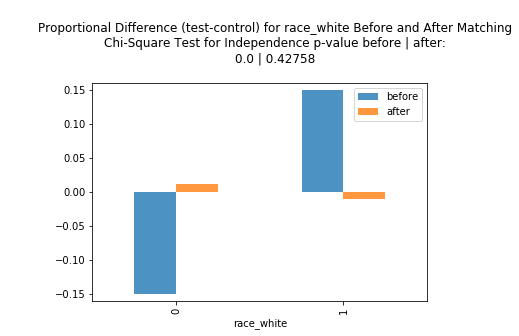

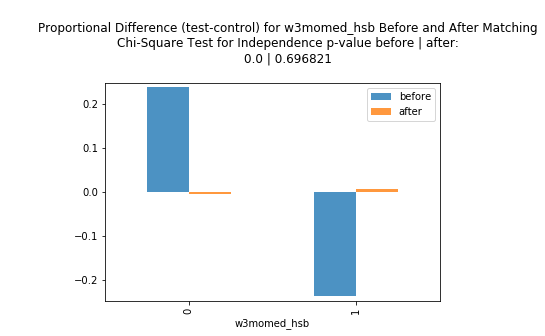

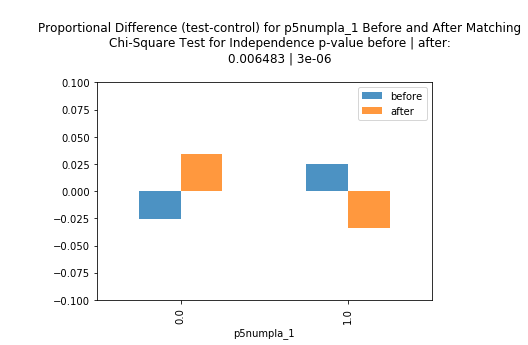

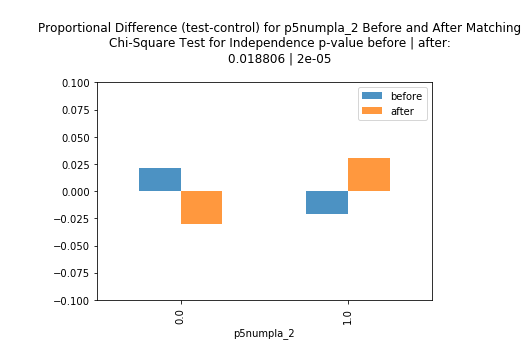

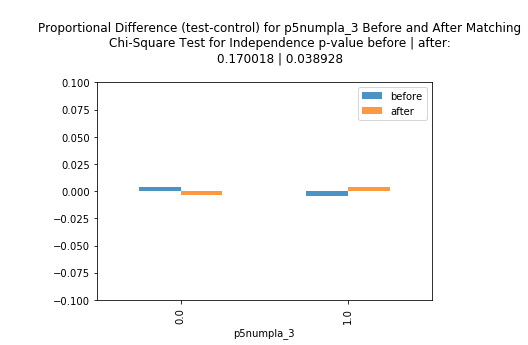

In [366]:
categorical_results = m.compare_categorical(return_table=True)

In [367]:
categorical_results

,var,before,after
0,race_white,0.000,0.428
1,w3momed_hsb,0.000,0.697
2,p5numpla_1,0.006,0.000
3,p5numpla_2,0.019,0.000
4,p5numpla_3,0.170,0.039


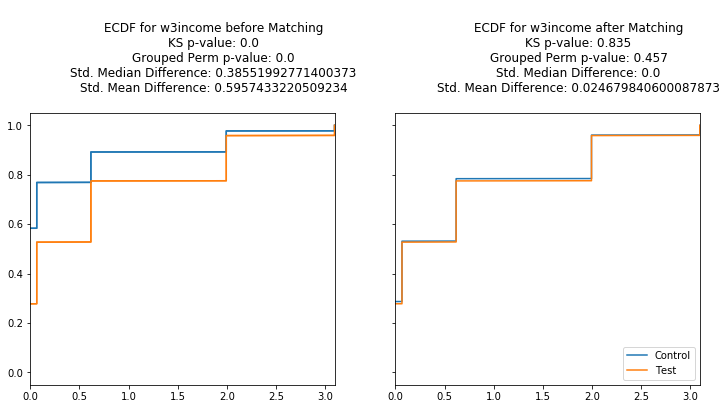

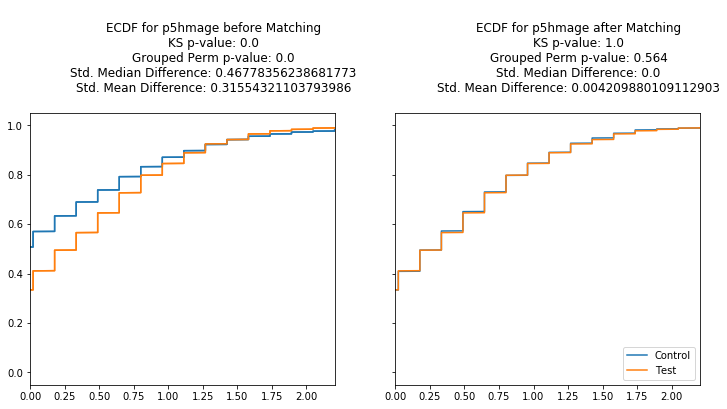

In [368]:
cc = m.compare_continuous(return_table=True)

In [369]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,w3income,0.000,0.835,0.000,0.457,0.386,0.000,0.596,0.025
1,p5hmage,0.000,1.000,0.000,0.564,0.468,0.000,0.316,0.004


In [370]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,catholic,c5r2mtsc,c5r2mtsc_sd,childid,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3,scores,match_id
0,0,1.000,1,64.604,1.399,0001011C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
2925,3155,0.067,0,52.827,0.180,0345019C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
3011,3266,0.067,0,58.998,0.819,0362020C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
5858,8033,0.067,0,62.595,1.191,1222021C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
2790,3031,0.067,0,49.185,-0.197,0325014C,1,0,0.617,0.021,1.000,0.000,0.000,0.622,0
5333,7079,0.333,0,56.411,0.551,1012019C,1,0,0.067,0.177,0.000,1.000,0.000,0.570,1


In [371]:
m.matched_data.shape

(6760, 15)

In [372]:
m.matched_data.shape[0]/5

1352.0

In [373]:
matching_analysis(m,numerical_features_list, binary_features_list_extended)

cohens d before
[0.6093310140823313, 0.31748850033605486]
cohens d after
[0.024677391964478487, 0.004209263267810509]
cohens h before
[0.9527005379402826, 0.9817899554717329, 1.6156036598214258, 0.3532625672538508, 0.10989507507767726]
cohens h after
[1.0599907011074903, 0.42465090780560316, 1.410399141448492, 0.1471433841725167, 0.008605434541985183]


,features,before,after
0,w3income,0.609,0.025
1,p5hmage,0.317,0.004
2,race_white,0.953,1.060
3,w3momed_hsb,0.982,0.425
4,p5numpla_1,1.616,1.410
5,p5numpla_2,0.353,0.147
6,p5numpla_3,0.110,0.009


#### Simulation

In [374]:
def simulations_for_deltas(test, control, trgt_column, match_column, sumulations_n):
    print("simulation for: " + trgt_column)
    print("n simulations: " + str(sumulations_n))
    
    trgt_value_control = test[trgt_column].mean()
    print("test target value mean (trt=0) : " + str(trgt_value_control))
    
    ids = set(control[match_column].tolist())
    
    sim_matched_control_sample = pd.concat(
        list(map(lambda x: resample(control.loc[control[match_column] == x]
                                , n_samples=sumulations_n
                                , replace=True)
             , ids)))
    sim_matched_control_sample['sim_id'] = list(range(sumulations_n))*len(ids)
    
    deltas = pd.pivot_table(data =sim_matched_control_sample
                       , index = ['sim_id']
                       , columns = None
                       , values = trgt_column
                       , aggfunc='mean')
    
    deltas[trgt_column + 'test_value'] = trgt_value_control
    deltas[trgt_column + '_delta'] = deltas[trgt_column] - trgt_value_control
    
    
    return(deltas)

In [375]:
sim_delta = simulations_for_deltas(test=m.matched_data.loc[m.matched_data[trt_column] == 1]
                      , control=m.matched_data.loc[m.matched_data[trt_column] == 0]
                      , trgt_column=trgt_column
                      , match_column='match_id'
                      , sumulations_n=sumulations_n)
print("delta control - test quantiles(empirical): [0.025, 0.5, 0.975]")
np.quantile(a = sim_delta[trgt_column + '_delta'], q = [0.025, 0.5, 0.975])

simulation for: c5r2mtsc_sd
n simulations: 500
test target value mean (trt=0) : 0.1508797691067188
delta control - test quantiles(empirical): [0.025, 0.5, 0.975]


array([0.0716558, 0.10868  , 0.150537 ])

#### 1:1 NN

In [376]:
m.match(method="min", nmatches=1, threshold=trs#,max_rand=2
       )

In [377]:
m.assign_weight_vector()

In [378]:
m.record_frequency()

,freq,n_records
0,1,1656
1,2,94
2,3,39
3,4,19
4,5,14
5,6,5
6,7,12
7,8,4
8,9,3
9,10,2


In [379]:
m.prop_retained()

1.0

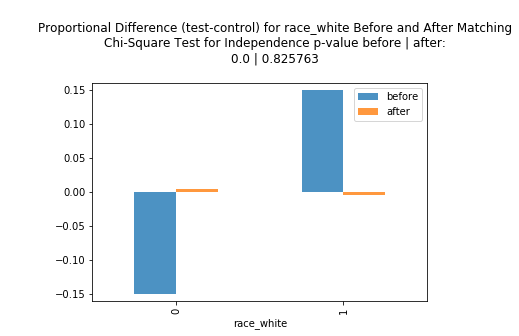

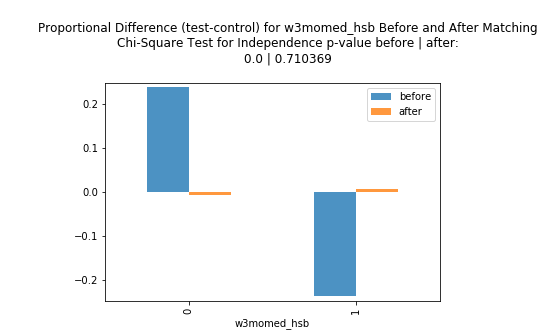

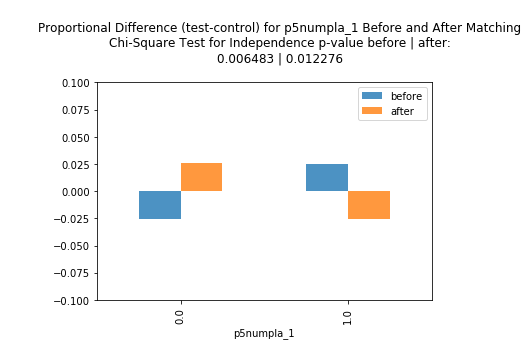

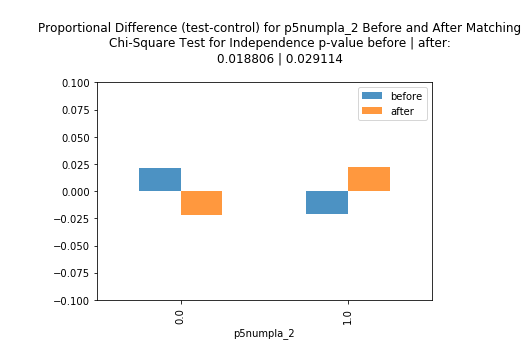

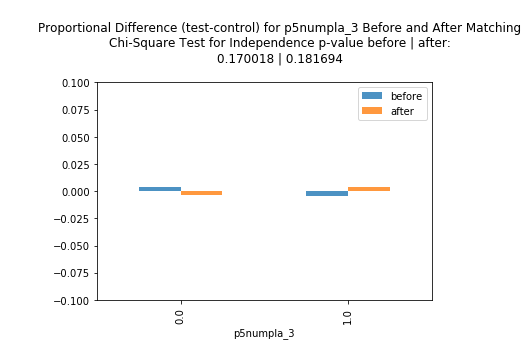

In [380]:
categorical_results = m.compare_categorical(return_table=True)

In [381]:
categorical_results

,var,before,after
0,race_white,0.000,0.826
1,w3momed_hsb,0.000,0.710
2,p5numpla_1,0.006,0.012
3,p5numpla_2,0.019,0.029
4,p5numpla_3,0.170,0.182


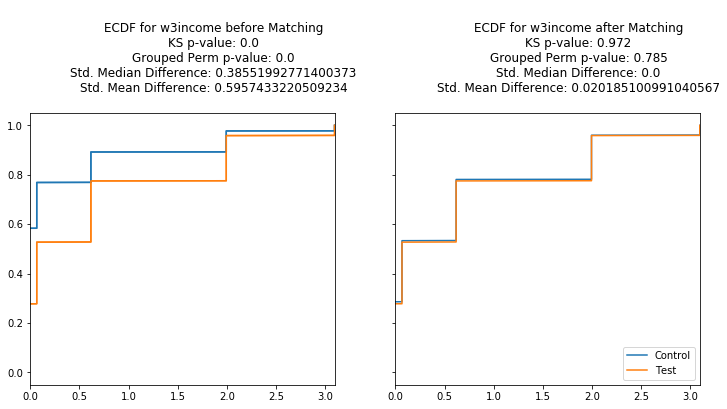

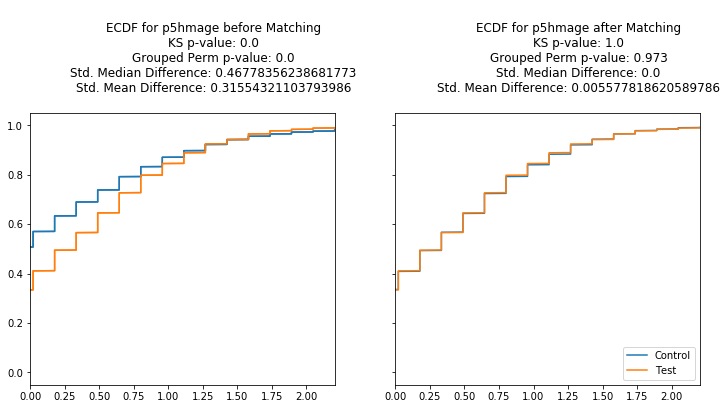

In [382]:
cc = m.compare_continuous(return_table=True)

In [383]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,w3income,0.000,0.972,0.000,0.785,0.386,0.000,0.596,0.020
1,p5hmage,0.000,1.000,0.000,0.973,0.468,0.000,0.316,0.006


In [384]:
matching_analysis(m,numerical_features_list, binary_features_list_extended)

cohens d before
[0.6093310140823313, 0.31748850033605486]
cohens d after
[0.02017866242713849, 0.005575777120550535]
cohens h before
[0.9527005379402826, 0.9817899554717329, 1.6156036598214258, 0.3532625672538508, 0.10989507507767726]
cohens h after
[0.004591691214716084, 0.010636830370501464, 0.025960152502929375, 0.060286438192112254, 0.045376796481663983]


,features,before,after
0,w3income,0.609,0.020
1,p5hmage,0.317,0.006
2,race_white,0.953,0.005
3,w3momed_hsb,0.982,0.011
4,p5numpla_1,1.616,0.026
5,p5numpla_2,0.353,0.060
6,p5numpla_3,0.110,0.045


In [385]:
sample_analysis(dt=m.matched_data
                ,trt_column=trt_column
                ,trgt_column=trgt_column
                ,one_parameter_str='c5r2mtsc_sd ~ catholic'
                ,many_parameter_str='c5r2mtsc_sd ~ catholic + race_white + p5hmage + w3momed_hsb + w3income + p5numpla_2'
               )

------------------
t-test

  Description catholic = 0
     metric            value
0      nobs             1352
1    minmax  (-2.808, 3.121)
2      mean            0.253
3  variance            1.037
------------------

  Description catholic = 1
     metric            value
0      nobs             1352
1    minmax  (-2.665, 3.011)
2      mean            0.151
3  variance            0.759
------------------

t.test data
Ttest_indResult(statistic=0.0, pvalue=1.0)

------------------
OLS for TRT parameter
------------------
                            OLS Regression Results                            
Dep. Variable:            c5r2mtsc_sd   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.916
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00494
Time:                        01:21:32   Log-Likelihood:                -3690.1

### Distane Based Matching

#### 1:N Matching

In [386]:
l = list(data_scaled.columns)
l.remove(trt_column)
l.remove(trgt_column_raw)
l.remove(trgt_column)
l.remove('childid')
print(l)

for c in clm:
    data_scaled[c] =data_scaled[c].astype('int')

['race_white', 'w3momed_hsb', 'w3income', 'p5hmage', 'p5numpla_1', 'p5numpla_2', 'p5numpla_3']


In [387]:
data_scaled_tmp = data_scaled
data_scaled_tmp.reset_index(inplace = True)
data_scaled_tmp.drop(labels='index', axis=1,inplace=True)

test_scaled = data_scaled_tmp.loc[data_scaled_tmp[trt_column] == 1,l]
control_scaled = data_scaled_tmp.loc[data_scaled_tmp[trt_column] == 0,l]

tree = BallTree(data_scaled[l], leaf_size=1) 
#tree = BallTree(control_scaled, leaf_size=1) 

In [388]:
t = tree.query_radius(test_scaled, r=rr, count_only=False)

In [389]:
#tmp = []
#for i in range(len(t)):
#    tmp = tmp + list(t[i])
#set(tmp)

#pd.DataFrame(list(set(tmp))).to_csv("tem.csv")

In [390]:
#tmp = list(t[3])
#tmp.sort()
#tmp

In [391]:
indexes_test = list(test_scaled.index)

In [392]:
for i in range(len(t)):
    t_initial_df = pd.DataFrame({'matched_index': list(t[i])})
    t_cleaned = np.array(t_initial_df[~t_initial_df.matched_index.isin(indexes_test)]['matched_index'].tolist())
    t[i] = t_cleaned

Text(0.5, 0, '$NumberOfMatchedObservationFromControlCensoredOn500$')

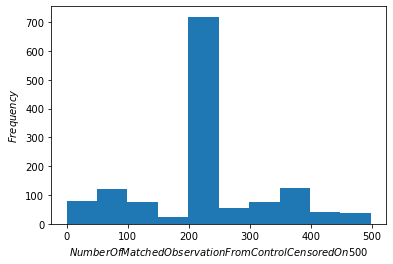

In [393]:
counts_mtaches = [ 200 if (len(ti)> 500)  else len(ti)  for ti in t]
plt.hist(counts_mtaches, normed=False)
plt.ylabel('$Frequency$')
plt.xlabel('$NumberOfMatchedObservationFromControlCensoredOn500$')

In [394]:
print("observations with no match")
for i in range(len(t)):
    if (len(t[i])==0):
        print(i)

observations with no match
415
1232


In [395]:
test_scaled['record_id'] = test_scaled.index
control_scaled['record_id'] = control_scaled.index

test_scaled[trgt_column] = data_scaled.loc[data_scaled[trt_column] == 1][trgt_column].tolist()
control_scaled[trgt_column] = data_scaled.loc[data_scaled[trt_column] == 0][trgt_column].tolist()
test_scaled[trt_column] = 1
control_scaled[trt_column] = 0

missed_test = []
matched_list = []
test_match_id_list = []
control_single = []
for i in range(len(t)):
#for i in range(10):
    #print(i)
    if (len(t[i])==0):
        missed_test.append(test_scaled.index[i]) ##we define indexes of observation that did not find a match
    else:
        match_id_i = test_scaled.index[i]
        #print(match_id_i)
        test_match_id_list.append(match_id_i)
        cntrl_index_list = t[i]#[control_scaled.index[j] for j in t[i]]
        #print(cntrl_index_list)
        ii = resample(cntrl_index_list, n_samples=1, replace=True)[0]
        #print(ii)
        matched_sample_i = control_scaled.loc[control_scaled.index.isin(cntrl_index_list)]
        matched_sample_i['match_id'] = match_id_i
        control_single.append(matched_sample_i.loc[matched_sample_i.index == ii])
        if(matched_sample_i.loc[matched_sample_i.index == ii].shape[0] == 0):
            print("Hey")
            print(i)
            print(match_id_i)
            print(cntrl_index_list)
            print(ii)
        matched_list.append(matched_sample_i)
        
test_matched_sample_distance_based = test_scaled.loc[test_scaled.index.isin(test_match_id_list)]
test_matched_sample_distance_based['match_id'] = test_scaled['record_id']
control_matched_sample_distance_based = pd.concat(matched_list,ignore_index=True)

single_control_matched_sample_distance_based = pd.concat(control_single,ignore_index=True)

In [396]:
single_control_matched_sample_distance_based.shape

(1350, 11)

In [397]:
print(test_matched_sample_distance_based.shape)
print(test_scaled.shape)

(1350, 11)
(1352, 10)


In [398]:
control_matched_sample_distance_based.head()

,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3,record_id,c5r2mtsc_sd,catholic,match_id
0,1,0,0.067,0.801,1,0,0,2,0.433,0,3
1,1,0,0.067,0.489,1,0,0,6,0.327,0,3
2,1,0,0.067,0.021,1,0,0,13,0.691,0,3
3,1,0,0.617,0.177,1,0,0,25,0.343,0,3
4,1,0,0.067,-0.135,1,0,0,26,1.968,0,3


In [399]:
test_matched_sample_distance_based.head()

,race_white,w3momed_hsb,w3income,p5hmage,p5numpla_1,p5numpla_2,p5numpla_3,record_id,c5r2mtsc_sd,catholic,match_id
3,1,0,0.617,0.021,1,0,0,3,1.399,1,3
32,1,0,0.067,0.177,0,1,0,32,0.098,1,32
33,1,0,1.994,0.489,0,1,0,33,1.433,1,33
34,1,0,0.617,-0.447,1,0,0,34,-0.564,1,34
35,1,0,1.994,0.489,1,0,0,35,-0.265,1,35


###### 1:N Matching Analysis

In [400]:
sim_delta_dist = simulations_for_deltas(test=test_matched_sample_distance_based
                      , control=control_matched_sample_distance_based
                      , trgt_column=trgt_column
                      , match_column='match_id'
                      , sumulations_n=sumulations_n)
np.quantile(a = sim_delta_dist[trgt_column + '_delta'], q = [0.025, 0.5, 0.975])

simulation for: c5r2mtsc_sd
n simulations: 500
test target value mean (trt=0) : 0.1520955965831412


array([0.08346983, 0.13441617, 0.17824511])

###### 1:1 Matching Analysis

In [401]:
many_parameter_str =  'c5r2mtsc_sd ~ catholic + race_white + p5hmage + w3momed_hsb + w3income + p5numpla_2'
sample_analysis(dt=pd.concat([test_matched_sample_distance_based
                             ,single_control_matched_sample_distance_based]
                            ,ignore_index=True)
                ,trt_column=trt_column
                ,trgt_column=trgt_column
                ,one_parameter_str='c5r2mtsc_sd ~ catholic'
                ,many_parameter_str= many_parameter_str
               )

------------------
t-test

  Description catholic = 0
     metric            value
0      nobs             1350
1    minmax  (-3.029, 3.391)
2      mean            0.267
3  variance            0.927
------------------

  Description catholic = 1
     metric            value
0      nobs             1350
1    minmax  (-2.665, 3.011)
2      mean            0.152
3  variance            0.759
------------------

t.test data
Ttest_indResult(statistic=0.0, pvalue=1.0)

------------------
OLS for TRT parameter
------------------
                            OLS Regression Results                            
Dep. Variable:            c5r2mtsc_sd   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00121
Time:                        01:23:20   Log-Likelihood:                -3599.9

### R vs Python analysis on the same data

In [402]:
if (path == path_to_catholic_vs_math_data):
    r_data = pd.read_csv('MatchingR.csv', header = 0, sep=";")
    r_data.columns

In [403]:
print(r_data.shape)
r_data.head()

(9267, 10)


,target_metric,childid,trt,race_white,p5hmage,w3income,p5numpla,w3momed_hsb,matched,initial_id
0,0.982,0001002C,0,1,47,"62,500.500",1,0,-1,1
1,0.594,0001004C,0,1,41,"45,000.500",1,0,-1,2
2,0.491,0001010C,0,1,43,"62,500.500",1,0,-1,4
3,1.451,0001011C,1,1,38,"87,500.500",1,0,6195,5
4,2.596,0001012C,0,1,47,"150,000.500",1,0,-1,6


In [404]:
l = r_data.loc[r_data.matched>-1]['matched'].tolist()
test_tmp = r_data.loc[(r_data.trt == 1)]
control_tmp = r_data.loc[(r_data.initial_id.isin(l))]

In [405]:
test_tmp.loc[test_tmp.index.isin(control_tmp.index)]

,target_metric,childid,trt,race_white,p5hmage,w3income,p5numpla,w3momed_hsb,matched,initial_id


In [406]:
control_tmp.loc[control_tmp.index.isin(test_tmp.index)]

,target_metric,childid,trt,race_white,p5hmage,w3income,p5numpla,w3momed_hsb,matched,initial_id


In [407]:
many_parameter_str =  'target_metric ~ trt + race_white + p5hmage + w3momed_hsb + w3income + p5numpla'
sample_analysis(dt=pd.concat([test_tmp
                             ,control_tmp]
                            ,ignore_index=True)
                ,trt_column='trt'
                ,trgt_column='target_metric'
                ,one_parameter_str='target_metric ~ trt'
                ,many_parameter_str= many_parameter_str
               )

------------------
t-test

  Description trt = 0
     metric            value
0      nobs             1352
1    minmax  (-3.092, 3.434)
2      mean            0.373
3  variance            0.893
------------------

  Description trt = 1
     metric            value
0      nobs             1352
1    minmax  (-2.592, 3.055)
2      mean            0.210
3  variance            0.751
------------------

t.test data
Ttest_indResult(statistic=0.0, pvalue=1.0)

------------------
OLS for TRT parameter
------------------
                            OLS Regression Results                            
Dep. Variable:          target_metric   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     22.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-06
Time:                        01:23:21   Log-Likelihood:                -3570.8
No. Obser